In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, GlobalAveragePooling1D,Flatten, GlobalAveragePooling2D,GlobalMaxPool3D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import text, sequence
import matplotlib.pyplot as plt
from tensorflow.keras  import layers
import numpy as np
from sklearn.metrics import plot_confusion_matrix

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
max_features = 20000
maxlen = 100
embedding_dim = 128

In [ ]:
path  =  "/content/drive/MyDrive/new1/data/train.csv/train.csv"
train =  pd.read_csv(path)
train = train.sample(frac=1)

In [ ]:
list_sentences_train = train["comment_text"].fillna("CVxTz").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)

X_t = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
x_train, x_test = X_t[:111700], X_t[111700:]
y_train, y_test = y[:111700],  y[111700:]

In [ ]:
def create_ngram_set(input_list, ngram_value=2):
    gram_list = []
    for i in range(ngram_value):
        gram_list.append(input_list[i:])
    return set(zip(*gram_list))

def add_ngram(sequences, token_indice, ngram_range=2):
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list = np.append(new_list , token_indice[ngram])
        new_sequences.append(new_list)
    return new_sequences

In [ ]:
num_classes = len(list_classes)
ngram_range = 2
batch_size = 1024
epochs = 5
max_words = 20000
maxlen = 100
embedding_dims = 128


#y_train = tf.keras.utils.to_categorical(y_train, num_classes)
#y_test = tf.keras.utils.to_categorical(y_test, num_classes)

if ngram_range > 1:

    # Create set of unique n-gram from the training set    
    ngram_set = set()
    for input_list in x_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer
    # Integer values are greater than max_words in order
    # to avoid collision with existing features
    start_index = max_words + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_words is the highest integer that could be found in the dataset
    max_words = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(x_train, token_indice, ngram_range)
    x_test = add_ngram(x_test, token_indice, ngram_range)

# Pad the input vectors to ensure a consistent length
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

In [ ]:
#We normalize this data because some values are greater than 20000 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

print(x_train,len(x_train))
print(x_test,len(x_test))
print(y_train, len(y_train))
print(y_test, len(y_test))

[[3.19015951e-02 1.65029236e-01 1.65071370e-01 ... 1.93769454e-01
  9.70234729e-01 8.55749900e-01]
 [7.02535127e-02 1.65029236e-01 1.65071370e-01 ... 7.77431711e-01
  5.80106538e-01 5.30126223e-01]
 [2.20011001e-02 1.65029236e-01 1.65071370e-01 ... 5.69187725e-01
  1.68802873e-01 9.20623165e-03]
 ...
 [2.50012501e-04 4.60233700e-01 9.73488375e-01 ... 1.35278070e-01
  7.29094603e-01 1.99941056e-01]
 [3.17515876e-02 1.65029236e-01 1.65071370e-01 ... 5.85957781e-01
  7.19776629e-01 9.53945876e-01]
 [1.92409620e-01 7.99017159e-01 9.45432328e-01 ... 3.13140563e-01
  2.72653594e-01 3.46452285e-01]] 111700
[[4.28406987e-02 9.13802946e-05 4.84766950e-04 ... 4.90461040e-01
  3.22701304e-01 1.74054163e-01]
 [5.65537260e-03 4.46538759e-04 1.87894167e-06 ... 7.97393025e-01
  9.54399004e-01 9.57421359e-01]
 [1.60152145e-03 1.98964105e-03 3.02227767e-03 ... 3.91142937e-01
  1.22611504e-01 8.14817179e-01]
 ...
 [4.90465943e-03 1.03627138e-05 0.00000000e+00 ... 9.10351902e-01
  6.40073757e-01 7.667911

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [ ]:
file_path = "../models/weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, verbose=1, save_best_only=True, mode="min")
early = EarlyStopping(mode="min", patience=20)
callbacks_list = [checkpoint, early]  # early
batch_size = 64
epochs = 5

In [ ]:
def get_model_MLP():
    with tf.device("/device:GPU:0"):
        embed_size = 128
        inp = Input(shape=(maxlen,))
        x = Embedding(max_features, embed_size)(inp)
        x = Dense(1000, activation = "relu")(x)
        x = Flatten()(x)
        x = Dense(500, activation = "relu")(x)
        x = Dense(100, activation = "relu")(x)
        x = Dense(50, activation="relu")(x)
        x = Dense(10, activation = "relu")(x)
        x = Dense(6, activation="sigmoid")(x)
        model = Model(inputs=inp, outputs=x)
        model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
        return model

In [ ]:
model = get_model_MLP()
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 128)          2560000   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 100)         71600     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 50)                5050  

In [ ]:
model1 = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.3, callbacks=callbacks_list)

Epoch 1/5
1222/1222 [==============================] - ETA: 0s - loss: 0.1515 - accuracy: 0.8494
Epoch 00001: val_loss improved from inf to 0.14110, saving model to ../models/weights_base.best.hdf5
1222/1222 [==============================] - 247s 199ms/step - loss: 0.1515 - accuracy: 0.8494 - val_loss: 0.1411 - val_accuracy: 0.9939
Epoch 2/5
1222/1222 [==============================] - ETA: 0s - loss: 0.1437 - accuracy: 0.9742
Epoch 00002: val_loss improved from 0.14110 to 0.14105, saving model to ../models/weights_base.best.hdf5
1222/1222 [==============================] - 244s 200ms/step - loss: 0.1437 - accuracy: 0.9742 - val_loss: 0.1411 - val_accuracy: 0.9939
Epoch 3/5
1222/1222 [==============================] - ETA: 0s - loss: 0.1434 - accuracy: 0.9921
Epoch 00003: val_loss did not improve from 0.14105
1222/1222 [==============================] - 242s 198ms/step - loss: 0.1434 - accuracy: 0.9921 - val_loss: 0.1412 - val_accuracy: 0.9939
Epoch 4/5
1222/1222 [====================

In [ ]:
model.save_weights("../models/model_weights.h5")
with open("../models/model_architecture.json", "w") as f:
    f.write(model.to_json())

In [24]:
y_pred = model.predict(x_test, batch_size=1024, verbose=1)
print(y_pred)

47/47 [==============================] - 25s 532ms/step
[[0.0944851  0.01210406 0.05765539 0.00356728 0.05154589 0.00882831]
 [0.0944851  0.01210406 0.05765539 0.00356728 0.05154589 0.00882831]
 [0.0944851  0.01210406 0.05765539 0.00356728 0.05154589 0.00882831]
 ...
 [0.0944851  0.01210406 0.05765539 0.00356728 0.05154589 0.00882831]
 [0.0944851  0.01210406 0.05765539 0.00356728 0.05154589 0.00882831]
 [0.0944851  0.01210406 0.05765539 0.00356728 0.05154589 0.00882831]]


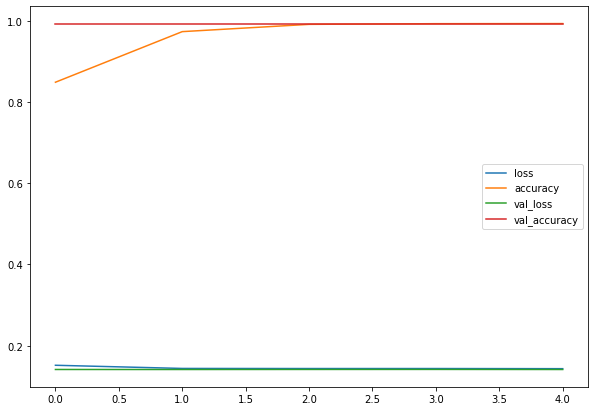

In [25]:
pd.DataFrame(model1.history).plot(figsize=(10, 7))

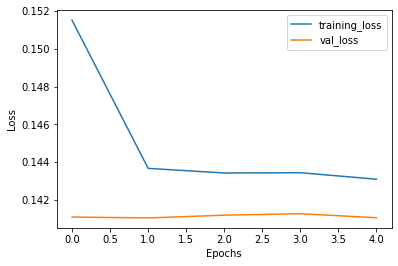

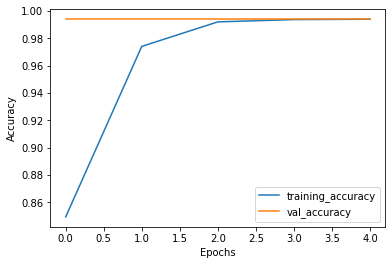

In [26]:
plot_loss_curves(model1)

In [27]:
y_pred1 = []
for i in  range(len(y_pred)):
 seq_prediction = list(map(lambda x: 0 if x<0.5 else 1, y_pred[i]))
 y_pred1.append(seq_prediction)
#print(seq_predictions[0])

#Convert y_test vector from [0 0 0 0 0 0] to [0,0,0,0,0,0] as y_test1
y_test1= []
for i in  range(len(y_test)):
 seq_prediction = list(map(lambda x: 0 if x<0.5 else 1, y_test[i]))
 y_test1.append(seq_prediction)
#print(y_test1)


In [28]:
y_test1 = np.array(y_test1)
y_pred1=np.array(y_pred1)

In [29]:
def Accuracy(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if  (sum(np.logical_or(y_true[i], y_pred[i]))==0):
             continue
        temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / y_true.shape[0]
    
def Hamming_Loss(y_true, y_pred):
    temp=0
    for i in range(y_true.shape[0]):
        temp += np.size(y_true[i] == y_pred[i]) - np.count_nonzero(y_true[i] == y_pred[i])
    return temp/(y_true.shape[0] * y_true.shape[1])

def Precision(y_true, y_pred):
      temp = 0
      for i in range(y_true.shape[0]):
          if sum(y_true[i]) == 0:
              continue
          temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_true[i])
      return temp/ y_true.shape[0]
                                
def Recall(y_true, y_pred):
      temp = 0
      for i in range(y_true.shape[0]):
          if sum(y_pred[i]) == 0:
              continue
          temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_pred[i])
      return temp/ y_true.shape[0]
                                
def F1Measure(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if (sum(y_true[i]) == 0) and (sum(y_pred[i]) == 0):
            continue
        temp+= (2*sum(np.logical_and(y_true[i], y_pred[i])))/ (sum(y_true[i])+sum(y_pred[i]))
    return temp/ y_true.shape[0]       


print("Accuracy:", Accuracy(y_test1, y_pred1))                        
print("Hamming Loss:", Hamming_Loss(y_test1, y_pred1))   
print("Precision:", Precision(y_test1, y_pred1))      
print("Recall:", Recall(y_test1, y_pred1))   
print("F1Measure:",F1Measure(y_test1, y_pred1))  
print("Exact Match Ratio:", np.all(y_pred1 == y_test1, axis=1).mean())
print("0/1 loss ratio:",np.any(y_test1 != y_pred1, axis=1).mean())

Accuracy: 0.0
Hamming Loss: 0.03633375808596715
Precision: 0.0
Recall: 0.0
F1Measure: 0.0
Exact Match Ratio: 0.8991665099956132
0/1 loss ratio: 0.1008334900043868


In [30]:
import sklearn.metrics
print('Exact Match Ratio: {0}'.format(sklearn.metrics.accuracy_score(y_test1, y_pred1, normalize=True, sample_weight=None)))
print('Zero one loss: {0}'.format(sklearn.metrics.zero_one_loss(y_true=y_test1, y_pred=y_pred1))) 
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_test1, y_pred1)))

Exact Match Ratio: 0.8991665099956132
Zero one loss: 0.1008334900043868
Hamming loss: 0.03633375808596715


In [31]:
#samples
print('Jaccard Score: {0}'.format(sklearn.metrics.jaccard_score(y_true=y_test1, y_pred=y_pred1,average='samples')))
print('Recall: {0}'.format(sklearn.metrics.precision_score(y_true=y_test1, y_pred=y_pred1, average='samples'))) 
print('Precision: {0}'.format(sklearn.metrics.recall_score(y_true=y_test1, y_pred=y_pred1, average='samples')))
print('F1 Measure: {0}'.format(sklearn.metrics.f1_score(y_true=y_test1, y_pred=y_pred1, average='samples'))) 



Jaccard Score: 0.0
Recall: 0.0
Precision: 0.0
F1 Measure: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-sc

In [32]:
#micro
print('Jaccard Score: {0}'.format(sklearn.metrics.jaccard_score(y_true=y_test1, y_pred=y_pred1,average='micro')))
print('Recall: {0}'.format(sklearn.metrics.precision_score(y_true=y_test1, y_pred=y_pred1, average='micro'))) 
print('Precision: {0}'.format(sklearn.metrics.recall_score(y_true=y_test1, y_pred=y_pred1, average='micro')))
print('F1 Measure: {0}'.format(sklearn.metrics.f1_score(y_true=y_test1, y_pred=y_pred1, average='micro'))) 


Jaccard Score: 0.0
Recall: 0.0
Precision: 0.0
F1 Measure: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
#macro
print('Jaccard Score: {0}'.format(sklearn.metrics.jaccard_score(y_true=y_test1, y_pred=y_pred1,average='macro')))
print('Recall: {0}'.format(sklearn.metrics.precision_score(y_true=y_test1, y_pred=y_pred1, average='macro'))) 
print('Precision: {0}'.format(sklearn.metrics.recall_score(y_true=y_test1, y_pred=y_pred1, average='macro')))
print('F1 Measure: {0}'.format(sklearn.metrics.f1_score(y_true=y_test1, y_pred=y_pred1, average='macro'))) 


Jaccard Score: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.0
Precision: 0.0
F1 Measure: 0.0


In [34]:
#weighted
print('Jaccard Score: {0}'.format(sklearn.metrics.jaccard_score(y_true=y_test1, y_pred=y_pred1,average='weighted')))
print('Recall: {0}'.format(sklearn.metrics.precision_score(y_true=y_test1, y_pred=y_pred1, average='weighted'))) 
print('Precision: {0}'.format(sklearn.metrics.recall_score(y_true=y_test1, y_pred=y_pred1, average='weighted')))
print('F1 Measure: {0}'.format(sklearn.metrics.f1_score(y_true=y_test1, y_pred=y_pred1, average='weighted'))) 


Jaccard Score: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.0
Precision: 0.0
F1 Measure: 0.0


In [35]:
print(sklearn.metrics.classification_report(y_test1, y_pred1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4569
           1       0.00      0.00      0.00       468
           2       0.00      0.00      0.00      2521
           3       0.00      0.00      0.00       141
           4       0.00      0.00      0.00      2313
           5       0.00      0.00      0.00       424

   micro avg       0.00      0.00      0.00     10436
   macro avg       0.00      0.00      0.00     10436
weighted avg       0.00      0.00      0.00     10436
 samples avg       0.00      0.00      0.00     10436



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [36]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test1, y_pred1)

array([[[43302,     0],
        [ 4569,     0]],

       [[47403,     0],
        [  468,     0]],

       [[45350,     0],
        [ 2521,     0]],

       [[47730,     0],
        [  141,     0]],

       [[45558,     0],
        [ 2313,     0]],

       [[47447,     0],
        [  424,     0]]])

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
cm = multilabel_confusion_matrix(y_test1, y_pred1)
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]


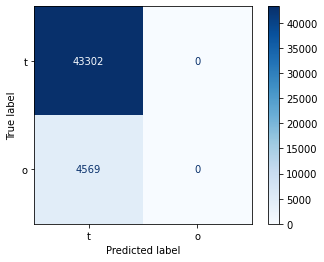

In [38]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm[0], display_labels=list_classes[0])
disp.plot(cmap=plt.cm.Blues)
plt.show()

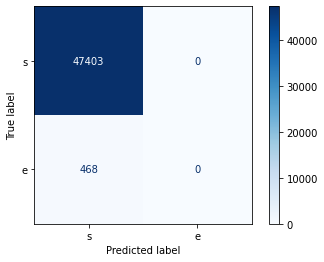

In [39]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm[1], display_labels=list_classes[1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

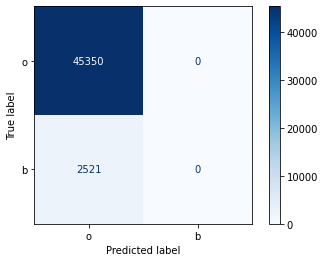

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm[2], display_labels=list_classes[2])

disp.plot(cmap=plt.cm.Blues)
plt.show()

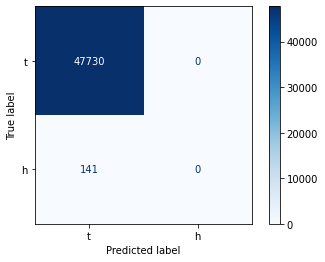

In [41]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm[3], display_labels=list_classes[3])
disp.plot(cmap=plt.cm.Blues)
plt.show()

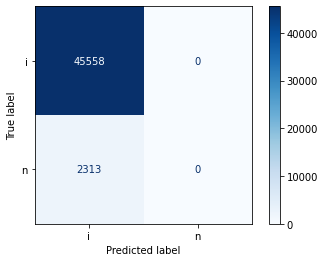

In [42]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm[4], display_labels=list_classes[4])

disp.plot(cmap=plt.cm.Blues)
plt.show()

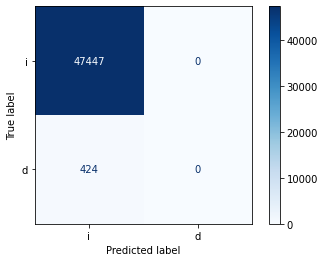

In [43]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm[5], display_labels=list_classes[5])

disp.plot(cmap=plt.cm.Blues)
plt.show()